# Quantum Monte-Carlo for Quantum Many-Body Systems

In this notebook, we apply the quantum Monte-Carlo method alongside with the variational method and neural network methods in order to find the ground state of a first quantized many-body systems. 

A general solution of a quantum many-body system $\Psi(\mathbf{r})$ must satisfy the quantum Schr\"odinger equation given by,

$$\hat{H}\Psi(\mathbf{r}) = E\Psi(\mathbf{r}),$$

where $E$ is the energy of the system in the state $\Psi(\mathbf{r})$, where $\mathbf{r}$ are the positions of all the quantum bodies in the system. We can see $\Psi$ as an eigenvector of the Hamiltonian operator $\hat{H}$ with eigenvalue $E$.

The general form of a many-body quantum Hamiltonian is given by,

$$\hat{H} = \hat{K} + \hat{V}$$
$$\hat{K} = -\sum_{i=1}^{N}\frac{\hbar^2}{2m_i}\hat{\nabla}^2_{\mathbf{r}_i}$$
$$\hat{V} = V(\{\mathbf{r}_i\}_{i=1}^{N})$$

where we have defined $\mathbf{r} = (\mathbf{r}_1, \mathbf{r}_2, \cdots, \mathbf{r}_N)$ with $\mathbf{r}_i$ the position vector for the particle $i$, and $\hat{V}$ is the potential energy operator, that only depends on the potitions of all the quantum bodies of the systems.

For molecular systems, we can define the general form of the Hamiltonian as,

$$\hat{H} = \hat{K} + \hat{V}$$
$$\hat{K} = -\sum_{i=1}^{N_n}\frac{\hbar^2}{2M_i}\hat{\nabla}^2_{\mathbf{R}_i} - \sum_{j=1}^{N_e}\frac{\hbar^2}{2m_j}\hat{\nabla}^2_{\mathbf{r}_j}$$
$$\hat{V} = \hat{V}_{ee}(\{\mathbf{r}_j\}_{j=1}^{N_e}) + \hat{V}_{nn}(\{\mathbf{R}_i\}_{i=1}^{N_n}) + \hat{V}_{en}(\{\mathbf{R}_i\}_{i=1}^{N_n}, \{\mathbf{r}_j\}_{j_1}^{N_e})$$

where $\hat{K}$ is the kinetic energy for all the nuclei and electrons in the molecular system, $\hat{V}$ is the potential energy, with $\hat{V}_{ee}$ the Coulumb potential between electrons, $\hat{V}_{nn}$ the Coulomb potential between nuclei and $\hat{V}_{en}$ the Coulomb potential between electrons and nuclei, $\{\mathbf{R}_i\}_{i=1}^{N_n}$ are the position vectors for all the nuclei in the molecular system, and $\{\mathbf{r}_j\}_{j=1}^{N_e}$ are the position vectors for the electrons.


As a first approximation, we study the One-Dimensional Harmonic Oscillator system.

## One-Dimensional Harmonic Oscilator

### Hamiltonian

We can compute the energy of the system for a given state $\Psi$ as follow:

$$E[\Psi] = \frac{\int \Psi^\dagger (\mathbf{R})\hat{H}\Psi(\mathbf{R})d\mathbf{R}}{\int\left|\Psi(\mathbf{R}')\right|^2 d\mathbf{R}'} = \int P(\mathbf{R})E_{loc}(\mathbf{R})d\mathbf{R},$$

where,

$$P(\mathbf{R}) = \frac{|\Psi(\mathbf{R})|^2}{\int |\Psi(\mathbf{R}')|^2 d\mathbf{R}'}$$
$$E_{loc} (\mathbf{R}) = \frac{\hat{H}\Psi(\mathbf{R})}{\Psi (\mathbf{R})}$$

where we can identify $P(\mathbf{R})$ as the probability distribution of the positions of particles in the system for the specific state $\Psi$, and $E_{loc} (\mathbf{R})$ is the local energy  of the system in that state for a given position of the particles. So, in order to get the energy for a given state, we need to compute the above integral in all the space.

In order to explain how to do this, we first get as a first approach the One-Dimensional Harmonic Oscillator system, where its Hamiltonian is given by,

$$\hat{H} = \hat{K} + \hat{V} = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + \frac{1}{2}m\omega^2 x^2,$$

where $m$ is the mass of the particle in the oscillating potential, and $\omega$ gives the oscillation frequency of this potential.

We start this exercise writing the class for this Hamiltonian.

In [10]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Class for the 1D - Harmonic Oscillator (OneDHO)

class OneDHO_Hamiltonian:

    '''
    Class that calculate Local Energies and variational energies of a given
    trial wavefunctions.

    mass:
        Mass of the particle in the 1D Harmonic Oscillator potential.
    omega:
        Frequency of oscillation of the harmonic oscillator
    hbar:
        The value of hbar considered
    potential_energy_fn:
        Function of the one dimensional potential if not harmonic oscilator.
    '''

    def __init__(self, mass=1.0, omega=1.0, hbar=1.0):
        self.mass = mass
        self.omega = omega
        self.hbar = hbar

    @partial(jax.jit, static_argnums=(0,))
    def kinetic_energy(self, psi, psi_laplacian):
        """
        Calculates local kinetic energy for a given value of the wavefunction and
        laplacian.
        ---------------------
        Input:

        psi:
            Value of the variational wavefunction for a given position Ψ(r).
        psi_laplacian:
            Value of the variational laplacian for a given position ∇²Ψ(r).

        ---------------------
        Output:

        Local kinetic energy:
            -(hbar^2/2m)∇²Ψ(r)/Ψ(r)
        """
        return -(((self.hbar)**2)/(2 * self.mass)) * psi_laplacian / psi


    @partial(jax.jit, static_argnums=(0,))
    def potential_energy(self, position):
        """
        Calculates local potential energy for a given potition.
        ---------------------
        Input:

        position:
            The position of the particle.

        ---------------------
        Output:

        Local potential energy:
            0.5 * omega^2 * mass * position^2
        """
        return 0.5 * self.mass * (self.omega ** 2) * jnp.sum(jnp.square(position))

    @partial(jax.jit, static_argnums=(0,))
    def total_energy(self, position, psi, psi_laplacian):
        """
        Calculates local total energy for a given potition.
        ---------------------
        Input:

        position:
            The position of the particle.
        psi:
            Value of the variational wavefunction for a given position Ψ(r).
        psi_laplacian:
            Value of the variational laplacian for a given position ∇²Ψ(r).

        ---------------------
        Output:

        Local total energy:
            -(hbar^2/2m)∇²Ψ(position)/Ψ(position) + 0.5 * omega^2 * mass * position^2
        """
        kinetic = self.kinetic_energy(psi, psi_laplacian)
        potential = self.potential_energy(position)
        return kinetic + potential

    @partial(jax.jit, static_argnums=(0,))
    def variational_energy(self, psi, positions, psi_laplacians):
        return jnp.mean(self.total_energy_vmap(psi, positions, psi_laplacians))

    #######################
    # vmapped functions
    #######################

    @partial(jax.vmap, in_axes = (None, 0, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def kinetic_energy_vmap(self, psi, psi_laplacian):
        return -0.5 * (((self.hbar)**2)/(2 * self.mass)) * psi_laplacian / psi

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def potential_energy_vmap(self, positions):
        return 0.5 * self.omega * self.mass * (self.omega ** 2) * jnp.sum(jnp.square(positions))

    @partial(jax.vmap, in_axes = (None, 0, 0, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def total_energy_vmap(self, psi, positions, psi_laplacian):
        kinetic = self.kinetic_energy(psi, psi_laplacian)
        potential = self.potential_energy(positions)
        return kinetic + potential

With this instanciated python class, we can calculate the value of the local energy $E_{loc}$ of the system for a given state in a given position of the particle.

Lets first instanciate a Hamiltonian in atomic units, that is, $\hbar = m = \omega = 1$.

In [4]:
hamiltonian = OneDHO_Hamiltonian()

Suppose that the value of the wavefunction at $x=0.5$ is $\Psi(x) = 0.8824969$, and the laplacian at that value of $x$ is $\nabla^2 \Psi(0.5) = -0.6618727$ (this are the actual values of the Gaussian wavefunction introduced forward for $\alpha = 0.5$). We can calculate the local kinetic energy, the local potential energy and the local energy for this given example as follows.

In [5]:
x = 0.5
psi = 0.8824969
laplacian = -0.6618727

# Get the local kinetic energy
local_kinetic_energy = hamiltonian.kinetic_energy(psi, laplacian)

# Get the local potential energy
local_potential_energy = hamiltonian.potential_energy(x)

# Get the local energy
local_energy = hamiltonian.total_energy(x, psi, laplacian)

print("For x = 0.5 and a Gaussian state with alpha=0.5:")
print(f"Local kinetic energy: {local_kinetic_energy}")
print(f"Local potential energy: {local_potential_energy}")
print(f"Local energy: {local_energy}")

For x = 0.5 and a Gaussian state with alpha=0.5:
Local kinetic energy: 0.375
Local potential energy: 0.125
Local energy: 0.5


### Variational wavefunction: Gaussian function

As a first approximation, lets propose a Gaussian of the form:

$$\Psi(x) = \exp(-\alpha x^2),$$

where $\alpha$ is the variational parameter to optimize. In the follow cell, the class for this wavefunction is created.

In [ ]:
class GaussianWaveFunction:
    def __init__(self, params=None):
        if params == None:
            params = jnp.array(np.random.normal())
        self.params = params

    @partial(jax.jit, static_argnums=(0,))
    def evaluate_wf(self, position):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = self.params[0]
        return jnp.exp(-alpha * position**2)

    @partial(jax.jit, static_argnums=(0,))
    def evaluate_log_wf(self, params, position):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = params[0]
        return jnp.log(jnp.exp(-alpha * position**2))

    @partial(jax.jit, static_argnums=(0,))
    def probability_function(self, position):
        return self.evaluate_wf(position)**2

    @partial(jax.jit, static_argnums=(0,))
    def grad_wf(self, position):
        return jax.grad(self.evaluate_wf, argnums=0)(position)

    @partial(jax.jit, static_argnums=(0,))
    def laplacian_wf(self, position):
        return jax.grad(self.grad_wf, argnums = 0)(position)

    @partial(jax.jit, static_argnums=(0,))
    def var_log_grads(self, params, position):
        return jax.grad(self.evaluate_log_wf, argnums=0)(params, position)

    #######################
    # vmapped functions
    #######################

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def evaluate_wf_vmap(self, positions):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = self.params[0]
        return jnp.exp(-alpha * positions**2)

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def grad_wf_vmap(self, positions):
        return jax.grad(self.evaluate_wf, argnums=0)(positions)

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def laplacian_wf_vmap(self, positions):
        return jax.grad(self.grad_wf, argnums = 0)(positions)

    @partial(jax.vmap, in_axes = (None, None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def var_log_grads_vmap(self, params, position):
        return jax.grad(self.evaluate_log_wf, argnums=0)(params, position)

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def probability_function_vmap(self, position):
        return self.evaluate_wf(position)**2

With this class, we can instantiate a Gaussian wavefunction given a variational parameter $\alpha$ as follow.

In [7]:
alpha = 0.5
trial_wf = GaussianWaveFunction([jnp.array(alpha)])

# Calculate values used before

x = 0.5

psi = trial_wf.evaluate_wf(x)
laplacian = trial_wf.laplacian_wf(x)

print(f"For x = {x}:")
print(r"$\Psi(x)$ = {}".format(psi))
print(r"$\nabla^2 \Psi (x)$ = {}".format(laplacian))

For x = 0.5:
$\Psi(x)$ = 0.8824968934059143
$\nabla^2 \Psi (x)$ = -0.6618726849555969


### Monte Carlo sampler

The before called trial wavefunction is a very simple function, and since it is one-dimensional, one can integrate very easily numerically. Nevertheless, when we have very complicated wavefunctions in multidimensional spaces, it might be very useful to use a Monte Carlo approach to approximate the observables of the quantum systems of such states. For this, we implement a very simple form of a Metropolis-Hastings algorithm to get samples from the probability distribution of the wavefunction.

In [ ]:
class MetropolisHastingsSampler:
    def __init__(self, trial_wavefunction, rng_key = None, step_size=0.01):
        if rng_key==None:
            rng_key = jax.random.PRNGKey(np.random.randint(10_000))
        self.step_size = step_size
        self.key = rng_key
        self.trial_wavefunction = trial_wavefunction

    @partial(jax.jit, static_argnums=(0,))
    def propose_move(self, positions, key):
        """Propose a new move by adding Gaussian noise to the current positions."""
        key, new_key = jax.random.split(key)
        move = jax.random.normal(new_key, shape=positions.shape) * self.step_size
        new_positions = positions + move
        return new_positions, key

    @partial(jax.jit, static_argnums=(0,))
    def acceptance_prob(self, old_positions, new_positions):
        """Compute the Metropolis-Hastings acceptance probability."""
        prob_old = self.trial_wavefunction.probability_function(position = old_positions)
        prob_new = self.trial_wavefunction.probability_function(position = new_positions)
        return jnp.minimum(1.0, prob_new / prob_old)

    @partial(jax.jit, static_argnums=(0,))
    def metropolis_step(self, positions, key):
        """Perform a single Metropolis-Hastings step."""
        key, sub_key = jax.random.split(key)
        new_positions, key = self.propose_move(positions, key)
        acc_prob = self.acceptance_prob(positions, new_positions)
        accept = jax.random.uniform(sub_key) < acc_prob
        positions = jnp.where(accept, new_positions, positions)
        return positions, key

    def sample(self, initial_positions, num_samples, burn_in=1_000):
        """Generate samples using Metropolis-Hastings with fori_loop."""

        # Define a burn-in loop function
        def sample_step(i, carry):
            positions, key = carry
            positions, key = self.metropolis_step(positions, key)
            return positions, key

        # Define a burn-in loop function
        def sample_scan(carry, x):
            positions, key = carry
            positions, key = self.metropolis_step(positions, key)
            return (positions, key), positions

        # Burn-in phase
        positions, key = jax.lax.fori_loop(0, burn_in, sample_step, (initial_positions, self.key))

        # Sampling phase
        (positions, key), samples = jax.lax.scan(sample_scan, (positions, key), None, num_samples)

        self.key = key

        return samples

In [9]:
trial = GaussianWaveFunction([jnp.array(0.4)])
sampler = MetropolisHastingsSampler(trial, step_size=0.1)
initial_positions = -0.5 + np.random.uniform()
samples = sampler.sample(initial_positions, num_samples=1_000_000, burn_in=25_000)

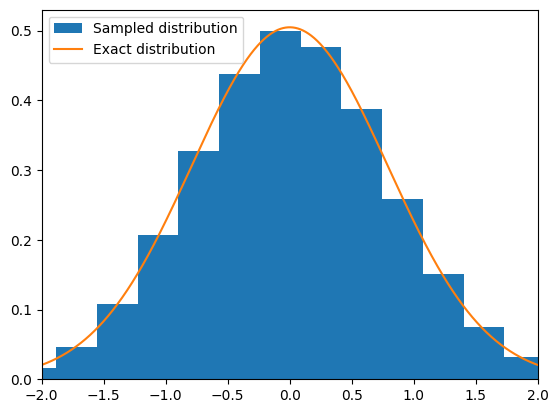

In [15]:
import scipy.integrate as integrate

x = np.linspace(-10, 10, 10_000)
integral = integrate.quad(lambda x: trial.probability_function(x), -10., 10.)[0]
y = trial.probability_function_vmap(x)/integral
plt.hist(samples, density=True, bins=20, label = 'Sampled distribution')
plt.plot(x, y, label='Exact distribution')
plt.xlim([-2., 2.])
plt.legend()
plt.show()

Now, lets calculate the variational energy for some values of $\alpha$.

In [16]:
from scipy.stats import sem
from matplotlib import pyplot as plt

energies = []
delta_energies = []
alpha_values = np.array([0.45, 0.475, 0.5, 0.525,0.55])
hamiltonian = OneDHO_Hamiltonian()
for alpha in alpha_values:
    trial = GaussianWaveFunction([jnp.array(alpha)])
    sampler = MetropolisHastingsSampler(trial, step_size=0.1)
    initial_positions = -0.5 + np.random.uniform()
    samples = sampler.sample(initial_positions, num_samples=1_000_000, burn_in=25_000)
    psi = trial.evaluate_wf_vmap(samples)
    laplacians = trial.laplacian_wf_vmap(samples)
    variational_energy = hamiltonian.total_energy_vmap(psi, samples, laplacians)
    energy, delta_energy = np.average(variational_energy), sem(variational_energy)
    energies.append(energy)
    delta_energies.append(delta_energy)
    print('%5.3f \t %7.5f ± %f' % (alpha,energy,delta_energy))

0.450 	 0.50195 ± 0.000073
0.475 	 0.50099 ± 0.000037
0.500 	 0.50000 ± 0.000000
0.525 	 0.50062 ± 0.000035
0.550 	 0.50189 ± 0.000067


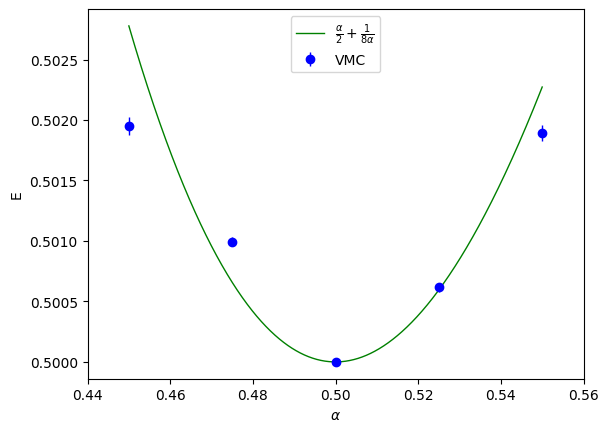

In [17]:
alpha = np.linspace(alpha_values[0],alpha_values[-1],1000)
plt.plot(alpha,0.5*alpha + 1/(8*alpha), '-', linewidth=1, color='green', zorder=-10,
         label=r'$\frac{\alpha}{2} + \frac{1}{8\alpha}$')
plt.errorbar(alpha_values,energies,yerr=delta_energies, linestyle='None', marker='o', elinewidth=1.0,
             markersize=6, markerfacecolor='blue', markeredgecolor='blue', ecolor='blue', label='VMC')
plt.xlabel(r'$\alpha$')
plt.ylabel('E');
plt.xlim(0.44,0.56)
plt.legend(loc='upper center')